In [1]:
import momi
import autograd.numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import logging
logging.basicConfig(level=logging.INFO, filename="new_tutorial.log")

In [2]:
# empty model with N_e=1.2e4, 29 time units (years) per generation
model = momi.demographic_model(default_N=1.2e4, gen_time=29)
# add YRI leaf at t=0 and default_N
model.add_leaf("YRI")
# add  CHB leaf at t=0, N=1e5, growing at rate 1e-3 per unit time (year)
model.add_leaf("CHB", N=1e5, g=5e-4)
# add NEA leaf at 50kya
model.add_leaf("NEA", t=5e4)

# stop CHB growth at 10kya
model.set_size("CHB", g=0, t=1e4)

# at 45kya CHB receive a 3% pulse from GhostNea
model.move_lineages("CHB", "GhostNea", t=4.5e4, p=.03)
# at 55kya GhostNea joins onto NEA
model.move_lineages("GhostNea", "NEA", t=5.5e4)

# at 80 kya CHB goes thru bottleneck
model.set_size("CHB", N=100, t=8e4)
# at 85 kya CHB joins onto YRI
model.move_lineages("CHB", "YRI", t=8.5e4)

# at 500 kya YRI joins onto NEA
model.move_lineages("YRI", "NEA", t=5e5)

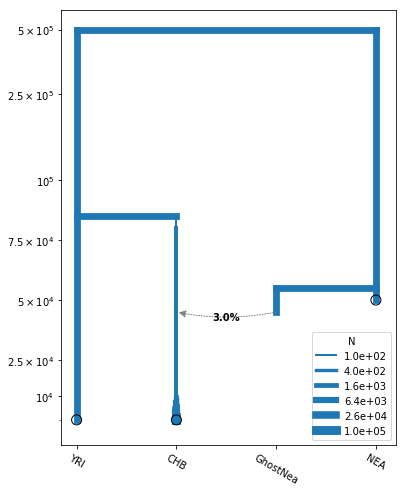

In [3]:
# plot the model
plt.figure(figsize=(6,8))
model.draw(["YRI", "CHB", "GhostNea", "NEA"], # specfiy pop order along the x-axis
            linthreshy=1e5) # linear scale up to 1e5, then logarithmic
plt.gca().set_yticks([1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5])

In [4]:
import gzip
import os

per_base_mut_rate = 1.25e-8
per_base_recom_rate = 1.25e-8
bases_per_locus = int(5e5)
n_loci = 20
ploidy = 2

# number of alleles to sample per population
sampled_n_dict = {"NEA":2, "YRI":4, "CHB":4}

# create data directory if it doesn't exist
os.makedirs("data", exist_ok=True) 

In [5]:
# simulate 20 "chromosomes", saving each in a separate gzipped vcf file
for chrom in range(n_loci):
    with gzip.open("data/{}.vcf.gz".format(chrom), "wt") as outfile:
        model.simulate_vcf(
            outfile,
            mutation_rate=per_base_mut_rate,
            recombination_rate=per_base_recom_rate,
            length=bases_per_locus,
            chrom_names=["chr{}".format(chrom)],
            ploidy=ploidy,
            random_seed=1234+chrom,
            sampled_n_dict=sampled_n_dict) 

In [6]:
## read in data from vcf

## first create a dict mapping samples to populations
ind2pop = {}
for pop, n in sampled_n_dict.items():
    for i in range(int(n / ploidy)):
        ## in the simulated vcfs, the samples are named like YRI_0, YRI_1, CHB_0, etc
        ind2pop["{}_{}".format(pop, i)] = pop

# uses REF as the ancestral allele
ancestral_alleles = False
## Other options:
## True: use the "AA" INFO field as the anc allele (skipping SNPs without this field)
## population name: use this population as the outgroup for polarizing

# Read in each vcf in a for loop
data = []
for chrom in range(n_loci):
    with gzip.open("data/{}.vcf.gz".format(chrom), "rt") as f:
        data.append(momi.SnpAlleleCounts.read_vcf(f, ind2pop,
                                                  ancestral_alleles))

# concatenate the 20 loci into a single dataset
data = momi.SnpAlleleCounts.concatenate(data)


In [7]:
## dump the momi-style data to a json file
with gzip.open("data/momi_data.json.gz", "wt") as f:
    data.dump(f)

## load the data back from the json file
with gzip.open("data/momi_data.json.gz", "rt") as f:
    data2 = momi.SnpAlleleCounts.load(f)

assert data == data2

In [8]:
## INFERENCE

## create a new model
model2 = momi.demographic_model(default_N=1.2e4, gen_time=29)

## set the data
model2.set_data(data,
                # use multinomial model, unfolded SFS
               muts_per_gen=None, folded=False,
                # splits data into 100 equally sized blocks
                # used to compute standard deviation of f4 and other stats
                # via block jackknife
               n_blocks_jackknife=100)

In [9]:
## start by fitting CHB and YRI

## define parameters of the model
model2.add_param("n_chb", x0=1.2e4)
model2.add_param("g_chb", x0=0,
                 # set bounds (defaults are lower=0,upper=inf)
                lower_x=-1e-3,upper_x=1e-3)
model2.add_param("t_chb_yri", x0=1e5, lower_x=1e4)

## add demographic events
model2.add_leaf("CHB", N="n_chb", g="g_chb")
model2.add_leaf("YRI")
model2.set_size("CHB", t=1e4, g=0)
model2.move_lineages("CHB", "YRI", t="t_chb_yri")

In [10]:
model2.optimize(method="L-BFGS-B")

      fun: 0.0018278408703278812
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -6.03125323e-05,   3.05167576e-02,  -4.87002817e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 19
      nit: 7
   status: 0
  success: True
        x: array([  1.11934564e+04,   2.57821825e-04,   1.07974160e+05])

In [11]:
print(model2.get_params())

ParamsDict({'n_chb': 11193.456449662002, 'g_chb': 0.00025782182476624319, 't_chb_yri': 107974.1595674338})


/home/jack/pythonpath/momi/demo_plotter.py:35: RuntimeWarning: invalid value encountered in double_scalars
  -self.curr_g * (nxt_t - self.curr_t))


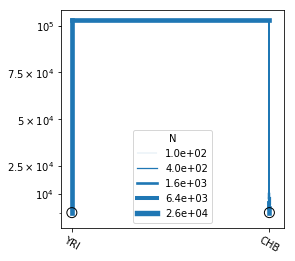

In [12]:
# plot the model
plt.figure(figsize=(4,4))
model2.draw(["YRI", "CHB"], linthreshy=1e5)
plt.gca().set_yticks([1e4, 2.5e4, 5e4, 7.5e4, 1e5])

In [13]:
## add NEA to the model

model2.add_leaf("NEA", t=5e4)

model2.add_param("t_anc", x0=5e4,
                 # force t_anc to be larger than 5e4, t_chb_yri,
                 # by setting t_anc = x + max(5e4, t_chb_yri)
                transform_x=lambda x,p: x + np.max([5e4, p.t_chb_yri]))

model2.move_lineages("YRI", "NEA", t="t_anc")

In [14]:
model2.optimize()

     fun: 0.011530688643198405
     jac: array([ -5.39571457e-06,  -2.68193679e-02,   9.32483363e-06,
         1.64435434e-05])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 30
     nit: 8
  status: 1
 success: True
       x: array([  1.08484101e+04,   2.60700016e-04,   9.91785888e+04,
         3.47974594e+05])

/home/jack/pythonpath/momi/demo_plotter.py:35: RuntimeWarning: invalid value encountered in double_scalars
  -self.curr_g * (nxt_t - self.curr_t))


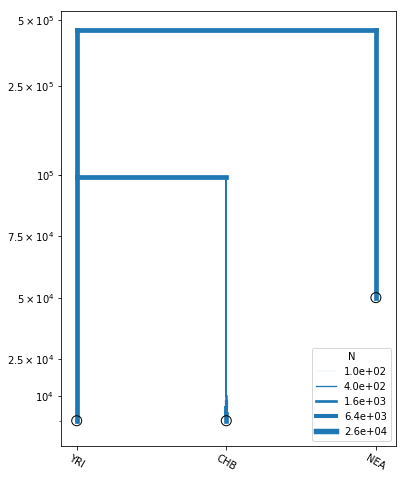

In [15]:
# plot the model
plt.figure(figsize=(6,8))
model2.draw(["YRI", "CHB", "NEA"], linthreshy=1e5)
plt.gca().set_yticks([1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5])

In [16]:
# model diagnostics
fstats = model2.fstats()
# f4(YRI, CHB, NEA, AncestralAllele) < 0 because of unmodeled Neanderthal admixture
# z_score is not significant because we only have a small dataset here
print(fstats.f4("YRI", "CHB", "NEA", None))

# also some functionality to check other statistics
# e.g. f2, f3, distance between every pair of populations
# (TODO: easily plot residuals of all pairwise distances)

ModelFitArray(expected=0.0, observed=-0.003722659074475776, sd=0.00308709634859539, z_score=-1.2058771914163169)


In [17]:
## create a new model with added NEA->CHB pulse

add_pulse_model = model2.copy()

add_pulse_model.add_param("p_pulse", x0=.1, lower_x=.000001, upper_x=.999999)
add_pulse_model.add_param("t_pulse", x0=.5, lower_x=0, upper_x=.99,
                        # t_pulse is between 0 and t_chb_yri
                        transform_x=lambda x,p: x*p.t_chb_yri)

add_pulse_model.move_lineages("CHB", "GhostNea", t="t_pulse", p="p_pulse")

add_pulse_model.add_param("t_ghost", x0=.5, lower_x=0, upper_x=1,
                          # require t_ghost to be between t_pulse and t_anc
                         transform_x=lambda x,p: x*np.max([p.t_pulse, 5e4]) + (1-x)*p.t_anc)
add_pulse_model.move_lineages("GhostNea", "NEA", t="t_ghost")

In [18]:
# stochastic gradient descent (ADAM+SVRG)
add_pulse_model.stochastic_optimize(snps_per_minibatch=1000, num_iters=10, svrg_epoch=3)

     fun: 14.168957935114822
     jac: array([ -5.58168161e-03,   4.17493685e+01,   8.46340616e-03,
        -1.80656633e-02,   2.24401382e-03,   3.03957012e-05,
        -1.52663444e-04])
 message: 'Maximum number of iterations reached'
     nit: 9
 success: False
       x: array([  8.12690432e+03,   1.00000000e-03,   1.05946266e+05,
         3.32595379e+05,   5.26889293e-02,   9.15008362e-01,
         6.45708619e-01])

In [19]:
# full gradient descent
add_pulse_model.optimize(method="TNC")

     fun: 0.0038129542970907261
     jac: array([  1.54086765e-06,  -9.96135888e-02,  -2.01281817e-06,
        -1.97789000e-05,  -1.75454132e-05,   6.03546400e-05,
        -9.50457873e-04])
 message: 'Max. number of function evaluations reached'
    nfev: 100
     nit: 22
  status: 3
 success: False
       x: array([  1.06871664e+07,   1.00000000e-03,   8.03828307e+04,
         3.92845926e+05,   6.33146799e-02,   4.36452469e-01,
         1.00000000e+00])

/home/jack/pythonpath/momi/demo_plotter.py:35: RuntimeWarning: invalid value encountered in double_scalars
  -self.curr_g * (nxt_t - self.curr_t))


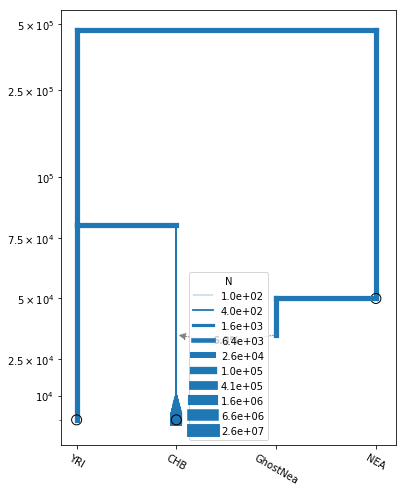

In [20]:
# plot the model
plt.figure(figsize=(6,8))
add_pulse_model.draw(["YRI", "CHB", "GhostNea", "NEA"], linthreshy=1e5)
plt.gca().set_yticks([1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5])

In [21]:
## generate nonparametric bootstrap datasets

n_bootstraps = 20
bootstrap_mles = []

# split dataset into 100 equally sized blocks to resample
chunked_data = data.chunk_data(100)

bootstrap_model = add_pulse_model.copy()
for bootstrap_it in range(n_bootstraps):
    print(bootstrap_it)
    # bootstrap resample blocks
    bootstrap_data = chunked_data.resample_chunks()
    
    bootstrap_model.set_data(bootstrap_data)
    # TODO: bootstrap_model.set_x(some_random_x0)
    bootstrap_model.optimize()
    bootstrap_mles.append(bootstrap_model.get_x())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


/home/jack/pythonpath/momi/demo_plotter.py:35: RuntimeWarning: invalid value encountered in double_scalars
  -self.curr_g * (nxt_t - self.curr_t))


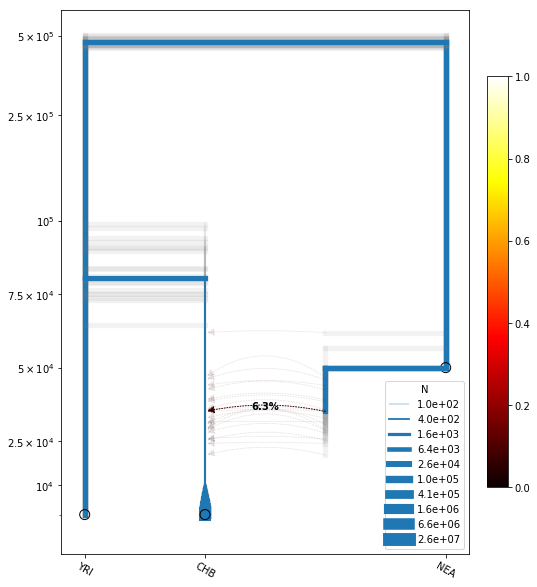

In [23]:
plt.figure(figsize=(8,10))
add_pulse_model.draw_with_bootstraps(bootstrap_mles,
                                     ["YRI", "CHB", "GhostNea", "NEA"], 
                                     linthreshy=1e5, p_min=0, p_max=1)
plt.gca().set_yticks([1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5])